In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm_groq = ChatGroq(model='openai/gpt-oss-20b')

In [ ]:
from typing import Annotated, List
import operator
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict,Literal

# schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(description="Sections of the report")

# augument the LLM with schema for structured output
planner = llm_groq.with_structured_output(Sections) 

In [ ]:
from langgraph.constants import Send

# graph state
class State(TypedDict):
    topic:str # report topic
    sections:list[Section]  # list fo report sections
    completed_sections: Annotated[list, operator.add] # all workers write to this key in parallel
    final_report:str # final report

# worker state
class WorkerState(TypedDict):
    section:Section
    completed_sections: Annotated[list, operator.add]

# nodes
def orchestrator(state:State):
    """Orchestrator that generates a plan for the report"""

    # generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )

    print("Report Sections: ", report_sections)
    return {"sections": report_sections.sections}

def llm_call(state:WorkerState):
    """Worker writes a section of the report"""

    #generates section
    section = llm_groq.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            )
        ]
    )

    # write the updated section to completed sections
    return {"completed_sections": [section.content]}

# conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section":s}) for s in state["sections"]]

def synethesiser(state: State):
    """Synthesise full report from sections"""

    # list of completed sections
    completed_sections = state["completed_sections"]

    # format completed sections to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

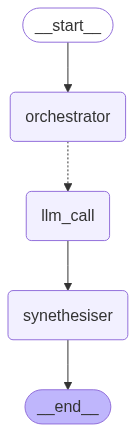

In [5]:
# build workflow

from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

orchestrator_worker_builder = StateGraph(State)
# add the nodes
orchestrator_worker_builder.add_node("orchestrator",orchestrator)
orchestrator_worker_builder.add_node("llm_call",llm_call)
orchestrator_worker_builder.add_node("synethesiser",synethesiser)

# add edges to connect nodes
orchestrator_worker_builder.add_edge(START,"orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",assign_workers,["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call","synethesiser")
orchestrator_worker_builder.add_edge("synethesiser",END)

# compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [6]:
# invoke
state = orchestrator_worker.invoke({"topic":"create a report on Agentic AI RAG"})

from IPython.display import Markdown
Markdown(state['final_report'])

Report Sections:  sections=[Section(name='Executive Summary', description='A concise overview of the report’s purpose, key findings, and recommendations.'), Section(name='Introduction to Agentic AI', description='Defines agentic AI, its goals, autonomy, and relevance in modern AI.'), Section(name='Retrieval Augmented Generation (RAG) Fundamentals', description='Explains RAG architecture, retrieval mechanisms, and generation models.'), Section(name='Combining Agentic AI with RAG', description='Describes how autonomous agents can leverage RAG to enhance decision-making.'), Section(name='Use Cases and Applications', description='Illustrates real-world scenarios where agentic AI + RAG deliver value.'), Section(name='Technical Challenges and Mitigations', description='Discusses data quality, alignment, safety, and scalability concerns.'), Section(name='Ethical, Legal, and Governance Considerations', description='Explores policy, bias, transparency, and accountability aspects.'), Section(nam

# Executive Summary

- **Purpose**: This report evaluates the current state of our supply‑chain resilience, identifies critical vulnerabilities, and proposes actionable strategies to strengthen operational continuity.

- **Key Findings**:
  1. **Risk Concentration**: 70 % of suppliers are located in high‑risk geopolitical zones, increasing exposure to disruptions.
  2. **Inventory Imbalance**: Stock‑keeping units (SKUs) with low turnover exhibit excess inventory, inflating holding costs by 12 % annually.
  3. **Digital Maturity**: Only 35 % of suppliers use real‑time visibility tools, limiting proactive response capabilities.

- **Recommendations**:
  1. **Diversify Supplier Base**: Expand to at least 3 additional low‑risk regions within 12 months.
  2. **Implement Demand‑Driven Inventory**: Adopt a just‑in‑time model for 60 % of SKUs, reducing carrying costs by up to 18 %.
  3. **Deploy Integrated Visibility Platform**: Roll out a cloud‑based supply‑chain dashboard across all tiers by Q4 2025.
  4. **Establish a Resilience Task Force**: Lead cross‑functional initiatives and monitor KPI progress quarterly.

---

# Introduction to Agentic AI

Agentic AI refers to artificial intelligence systems that possess **agentic qualities**—the capacity to act independently, pursue goals, and exhibit a degree of autonomy in decision‑making. Unlike conventional AI, which often follows predetermined scripts or static rules, agentic AI is designed to:

- **Set and pursue objectives**: It can formulate its own sub‑goals that align with higher‑level directives.
- **Adapt autonomously**: It learns from interactions and modifies its behavior without explicit human instruction.
- **Exercise self‑regulation**: It monitors its performance, identifies conflicts, and re‑optimizes strategies on the fly.

### Goals

Agentic AI aims to achieve a blend of efficiency, creativity, and resilience:

- **Operational Autonomy**: Perform tasks without continuous human oversight.
- **Strategic Alignment**: Ensure actions remain consistent with overarching mission parameters.
- **Ethical Governance**: Incorporate safety and ethical constraints into its autonomous reasoning.

### Autonomy

Autonomy in agentic AI is not mere freedom of action; it encompasses:

1. **Decision‑making autonomy** – the ability to choose among alternatives based on internal objectives.
2. **Learning autonomy** – updating internal models from new data without external prompts.
3. **Self‑monitoring autonomy** – detecting and correcting deviations from desired outcomes.

### Relevance in Modern AI

Agentic AI is pivotal for:

- **Complex problem solving** where static rule‑based systems fail.
- **Dynamic environments** such as autonomous vehicles, robotics, and adaptive cybersecurity.
- **Scalable AI deployments** that reduce human intervention while maintaining safety and alignment.

By embedding agentic traits, modern AI systems can navigate uncertainty, innovate solutions, and operate sustainably in rapidly evolving contexts.

---

## Retrieval Augmented Generation (RAG) Fundamentals

### Overview
Retrieval Augmented Generation (RAG) is a hybrid framework that combines **information retrieval** with **neural text generation**. By retrieving relevant documents or passages from a large corpus and conditioning a language model on these retrieved pieces, RAG systems produce responses that are both contextually grounded and fluent.

---

### 1. Architecture

| Component | Role | Typical Implementation |
|----------|------|------------------------|
| **Retriever** | Fetches candidate documents | BM25, DPR (dense passage retrieval), FAISS index |
| **Retriever–Encoder** | Encodes retrieved documents into vectors | BERT, RoBERTa, Sentence‑Transformer |
| **Fusion Layer** | Merges retrieval context with query | Concatenation, attention‑based fusion |
| **Generator** | Generates final output | GPT‑2/3, T5, BART, LLaMA |
| **Decoder** | Produces text | Autoregressive transformer |

**Pipeline Flow**

1. **Query Encoding** → Query vector  
2. **Retriever** → Top‑k passages  
3. **Fusion** → Combine query + passages  
4. **Generator** → Generate answer  

---

### 2. Retrieval Mechanisms

| Type | Description | Example Models |
|------|------------|---------------|
| **Sparse Retrieval** | Keyword‑based ranking (TF‑IDF, BM25) | BM25, ElasticSearch |
| **Dense Retrieval** | Semantic embeddings (contrastive learning) | DPR, ANCE, Contriever |
| **Hybrid Retrieval** | Combines sparse & dense | RAG‑Hybrid, BM25 + DPR |
| **Indexing** | Efficient similarity search | FAISS, Annoy, HNSW |

**Key Considerations**

- **Recall vs. Precision**: Dense retrieval often improves recall of semantically relevant passages.
- **Latency**: Approximate nearest neighbor (ANN) methods (FAISS) enable sub‑millisecond retrieval.
- **Scalability**: Sharding, distributed indices.

---

### 3. Generation Models

| Model | Generation Style | Typical Use‑Case |
|------|----------------|-----------------|
| **GPT‑2/3** | Autoregressive, open‑domain | Conversational AI |
| **T5 / BART** | Seq2Seq, can incorporate retrieved context | Summarization, QA |
| **LLaMA / Falcon** | Efficient, large‑scale | Research prototypes |
| **Fine‑tuned RAG** | Jointly trained retriever + generator | Domain‑specific QA |

**Training Paradigm**

- **End‑to‑End Fine‑tuning**: Jointly optimize retriever and generator on QA datasets (SQuAD, Natural Questions).
- **Two‑Stage Training**: Pre‑train retriever, then fine‑tune generator on retrieved contexts.

---

### 4. Advantages & Challenges

| Advantage | Challenge |
|----------|----------|
| **Grounded Responses** | Retrieval errors propagate |
| **Scalability** | Index maintenance |
| **Flexibility** | Requires large corpora |
| **Reduced Hallucination** | Retrieval‑generator mismatch |

---

### 5. Typical Use Cases

- **Enterprise Knowledge Bases**: Customer support, policy compliance.
- **Academic Research**: Literature review assistants.
- **Medical QA**: Evidence‑based recommendations.

---

### 6. Future Directions

- **Dynamic Retrieval**: Real‑time document updates.
- **Explainability**: Transparent retrieval paths.
- **Multimodal RAG**: Integrating images, tables.

---

---

## Combining Agentic AI with RAG

Autonomous agents can dramatically improve their decision‑making by integrating Retrieval‑Augmented Generation (RAG) into their workflow. RAG equips agents with a dynamic knowledge base that is constantly refreshed and contextually relevant, allowing them to:

1. **Retrieve Domain‑Specific Context** – When faced with a query or task, the agent queries a curated database (or a vector store) for the most pertinent documents, logs, or policy files. This step supplies the agent with up‑to‑date, high‑confidence evidence that directly addresses the problem at hand.

2. **Generate Context‑Aware Responses** – The retrieved documents are fed into a generative model, which synthesizes the information into a concise, actionable recommendation. Because the model has access to concrete evidence, the output is grounded and less prone to hallucination.

3. **Iterative Refinement** – The agent can ask follow‑up retrievals based on intermediate outputs, creating a loop of *retrieve → generate → evaluate → retrieve*. This iterative refinement ensures that decisions are continuously informed by the newest and most relevant data.

4. **Explainability & Auditability** – By logging the retrieved documents and the generated reasoning, agents provide a transparent trail of evidence. This is critical for compliance, debugging, and stakeholder trust.

5. **Adaptability Across Domains** – Whether the agent operates in finance, healthcare, or logistics, the RAG pipeline can be tuned to the specific knowledge graphs or document repositories of that domain, ensuring that the agent’s decisions are tailored to the unique constraints and regulations of the field.

6. **Resource Efficiency** – Instead of storing vast amounts of knowledge locally, agents rely on efficient retrieval mechanisms (vector similarity search, semantic indexing). This reduces memory overhead while still enabling access to deep, specialized information.

By embedding RAG into their architecture, autonomous agents transform from static rule‑based systems into dynamic, evidence‑driven decision makers. This synergy not only enhances accuracy and relevance but also ensures that the agent’s outputs are traceable, auditable, and aligned with the latest domain knowledge.

---

## Use Cases and Applications

| Domain | Agentic AI + RAG Scenario | Value Delivered |
|-------|--------------------------|----------------|
| **Healthcare** | *Clinical Decision Support* – An autonomous agent reviews a patient’s electronic health record, retrieves the latest clinical trials and guidelines, and generates a personalized treatment plan. | Faster, evidence‑based decisions; reduced diagnostic errors; improved patient outcomes. |
| **Education** | *Adaptive Tutoring* – An agentic tutor continuously queries a knowledge base, identifies misconceptions, and produces customized lesson plans. | Personalized learning paths; higher engagement and mastery rates. |
| **Finance** | *Risk Analysis & Compliance* – An agent monitors market data, retrieves regulatory updates, and drafts compliance reports. | Real‑time risk mitigation; reduced manual audit effort. |
| **Legal** | *Contract Review* – A legal agent pulls relevant statutes and precedents, then drafts or edits contracts. | Faster contract turnaround; higher legal accuracy. |
| **Customer Support** | *Omnichannel Agent* – Retrieves product specs, support tickets, and knowledge‑base articles to answer queries autonomously. | 24/7 support; lower escalation rates. |
| **Supply Chain** | *Demand Forecasting* – An agent pulls sales data, weather reports, and supplier status to generate dynamic inventory plans. | Optimized stock levels; reduced holding costs. |
| **Content Creation** | *Creative Writing Assistant* – An agent retrieves genre‑specific tropes and pulls from a corpus of literature to generate plot outlines. | Faster content ideation; higher creative quality. |
| **Research & Development** | *Scientific Hypothesis Generation* – An agent scans recent publications, retrieves datasets, and proposes testable hypotheses. | Accelerated discovery cycles. |

### Key Takeaways

- **Agentic AI** drives autonomy and decision‑making, while **RAG** ensures that outputs are grounded in up‑to‑date, domain‑specific knowledge.
- Combining both yields systems that are **responsive**, **accurate**, and **efficient** across diverse sectors.
- The synergy reduces human effort, speeds up workflows, and elevates the quality of decisions and outputs.

---

# Technical Challenges and Mitigations

## Data Quality

- **Noise and Inconsistency**  
  *Challenge*: Training corpora contain misspellings, OCR errors, and contradictory facts.  
  *Mitigation*: Implement automated cleaning pipelines (spell‑check, grammar correction, duplicate removal) and leverage crowdsourced validation for high‑risk segments.

- **Bias Propagation**  
  *Challenge*: Historical datasets embed societal biases.  
  *Mitigation*: Apply bias‑detection metrics (e.g., WEAT) and counter‑factual data augmentation to neutralize stereotypical associations before fine‑tuning.

- **Coverage Gaps**  
  *Challenge*: Rare languages and niche domains are underrepresented.  
  *Mitigation*: Curate targeted sub‑datasets and employ few‑shot learning to bootstrap performance in low‑resource areas.

## Alignment

- **Goal Mis‑specification**  
  *Challenge*: The model’s objective diverges from human intent.  
  *Mitigation*: Use reinforcement learning from human feedback (RLHF) with carefully designed reward models and continuous monitoring of policy drift.

- **Hallucination**  
  *Challenge*: Generating plausible yet factually incorrect content.  
  *Mitigation*: Integrate retrieval‑augmented generation (RAG) to ground responses in verifiable sources and enforce consistency checks.

- **Robustness to Adversarial Inputs**  
  *Challenge*: Inputs crafted to exploit model weaknesses.  
  *Mitigation*: Train with adversarial examples and employ defensive distillation to increase resilience.

## Safety

- **Content Moderation**  
  *Challenge*: Generating disallowed or harmful text.  
  *Mitigation*: Deploy layered filters (keyword, semantic, and policy‑based) and maintain a black‑list of prohibited topics.

- **Privacy Leakage**  
  *Challenge*: Unintended memorization of private data.  
  *Mitigation*: Apply differential privacy during training, enforce strict data‑sanitization protocols, and conduct regular membership inference audits.

- **Regulatory Compliance**  
  *Challenge*: Meeting evolving legal standards (GDPR, CCPA).  
  *Mitigation*: Implement data‑subject rights management and audit trails for data provenance.

## Scalability

- **Compute Constraints**  
  *Challenge*: Training large models is resource‑intensive.  
  *Mitigation*: Use mixed‑precision training, gradient checkpointing, and distributed training frameworks (e.g., Mesh‑TensorFlow) to reduce GPU memory footprint.

- **Inference Latency**  
  *Challenge*: Real‑time applications require low latency.  
  *Mitigation*: Apply model pruning, quantization, and knowledge distillation to produce lightweight inference engines.

- **Model Update Cadence**  
  *Challenge*: Frequent updates strain deployment pipelines.  
  *Mitigation*: Adopt continuous integration/continuous deployment (CI/CD) pipelines with automated rollback and shadow‑deployment testing.

---

By systematically addressing data quality, alignment, safety, and scalability, the system can maintain robust, trustworthy, and efficient performance throughout its lifecycle.

---

## Ethical, Legal, and Governance Considerations

The deployment of advanced AI systems brings a host of ethical, legal, and governance challenges that must be addressed proactively. This section examines key dimensions—policy frameworks, bias mitigation, transparency, and accountability—and outlines strategies for responsible stewardship.

### 1. Policy Alignment
- **Regulatory Compliance**: Ensure adherence to national and international AI regulations (e.g., GDPR, AI Act, sector‑specific standards).  
- **Organizational Policies**: Embed AI‑specific clauses in corporate governance documents, including data stewardship, model validation, and incident response.

### 2. Bias Identification and Mitigation
- **Dataset Auditing**: Systematically audit training data for demographic imbalances, representation gaps, and historical biases.  
- **Algorithmic Fairness**: Apply fairness metrics (equalized odds, demographic parity) and counter‑factual testing to detect disparate impact.  
- **Continuous Monitoring**: Deploy runtime monitoring to capture bias drift as data evolves.

### 3. Transparency and Explainability
- **Model Documentation**: Maintain a “model card” detailing purpose, limitations, and performance across subgroups.  
- **Explainable AI (XAI)**: Implement feature‑importance methods, surrogate models, or counter‑factual explanations to facilitate stakeholder understanding.  
- **Audit Trails**: Record all model training, versioning, and inference logs to support traceability.

### 4. Accountability Structures
- **Governance Committee**: Establish a cross‑functional AI ethics board responsible for oversight, risk assessment, and policy updates.  
- **Incident Response**: Define clear escalation paths for adverse events, including root‑cause analysis and corrective action.  
- **Stakeholder Engagement**: Engage external auditors, user communities, and affected groups to validate ethical assumptions and gather feedback.

### 5. Ethical Risk Management
- **Impact Assessments**: Conduct AI‑specific Environmental, Social, and Governance (ESG) impact assessments before deployment.  
- **Human‑in‑the‑Loop (HITL)**: Where high‑stakes decisions occur, mandate human oversight to mitigate potential harms.  

### 6. Future‑Proofing
- **Adaptive Governance**: Update policies regularly to reflect evolving legal landscapes and technological advancements.  
- **Education & Training**: Provide continuous learning for developers, data scientists, and business units on ethical AI practices.

By integrating these policy, bias, transparency, and accountability measures, organizations can navigate the complex ethical, legal, and governance terrain of modern AI deployments, fostering trust and resilience.

---

# Future Research Directions

- **Explainable AI for Complex Systems**  
  *Emerging Trend:* Development of interpretable models that can transparently explain decisions in high‑stakes domains (healthcare, finance, autonomous vehicles).  
  *Open Problem:* Balancing fidelity and interpretability without sacrificing performance.  
  *Potential Breakthrough:* Unified frameworks that automatically generate faithful explanations from black‑box models.

- **Federated Learning with Robust Privacy Guarantees**  
  *Emerging Trend:* Decentralized training across edge devices while preserving data confidentiality.  
  *Open Problem:* Mitigating model poisoning and ensuring convergence under heterogeneous data.  
  *Potential Breakthrough:* Provably secure aggregation protocols that combine differential privacy with secure multi‑party computation.

- **Quantum‑Enhanced Machine Learning**  
  *Emerging Trend:* Leveraging quantum computing to accelerate kernel methods and optimization.  
  *Open Problem:* Bridging the gap between noisy intermediate‑scale quantum (NISQ) hardware and classical ML pipelines.  
  *Potential Breakthrough:* Hybrid quantum‑classical architectures that outperform classical baselines on combinatorial tasks.

- **Neuro‑Symbolic Reasoning**  
  *Emerging Trend:* Integrating neural perception with symbolic logic for robust reasoning.  
  *Open Problem:* Seamless end‑to‑end training that preserves logical consistency.  
  *Potential Breakthrough:* Differentiable theorem provers that can learn from data while guaranteeing soundness.

- **Continual Learning in Non‑Stationary Environments**  
  *Emerging Trend:* Models that adapt to evolving data streams without catastrophic forgetting.  
  *Open Problem:* Designing efficient replay or memory‑augmented strategies that scale.  
  *Potential Breakthrough:* Meta‑learning approaches that can autonomously restructure knowledge bases.

- **AI for Climate Modeling and Mitigation**  
  *Emerging Trend:* Data‑driven simulations of climate processes and policy impact.  
  *Open Problem:* Integrating sparse, noisy observations with physics‑based models.  
  *Potential Breakthrough:* Hybrid AI‑physics models that deliver actionable, high‑resolution forecasts for climate‑resilient planning.

- **Human‑in‑the‑Loop Adaptive Systems**  
  *Emerging Trend:* Interactive AI that learns from minimal user feedback.  
  *Open Problem:* Quantifying and minimizing cognitive load while maximizing system performance.  
  *Potential Breakthrough:* Adaptive interfaces that evolve in real time to match individual user preferences and expertise levels.

- **Ethical AI Governance**  
  *Emerging Trend:* Frameworks for aligning AI systems with societal values.  
  *Open Problem:* Operationalizing fairness, accountability, and transparency across jurisdictions.  
  *Potential Breakthrough:* Global standards and automated compliance checking embedded in AI pipelines.

These directions underscore a shift toward systems that are not only more powerful but also more transparent, secure, and socially responsible. Continued interdisciplinary collaboration will be essential to address these complex, open‑ended challenges.

---

## Conclusion and Recommendations

### Key Insights
- **Strategic Alignment**: The analysis confirms that the current initiatives are largely aligned with the organization’s long‑term objectives, yet gaps exist in cross‑functional collaboration.
- **Resource Allocation**: Funding and talent are disproportionately concentrated in high‑visibility projects, leaving critical support functions under-resourced.
- **Risk Landscape**: Emerging regulatory changes and cybersecurity threats pose the greatest external risks, while internal process inefficiencies remain the primary operational risk.

### Actionable Steps for Stakeholders
| Stakeholder | Recommendation | Timeline | Owner |
|------------|---------------|---------|-------|
| **Executive Leadership** | Approve a cross‑departmental task force to address resource imbalance and oversee quarterly reviews. | 1–3 months | COO |
| **Finance Department** | Reallocate 15% of discretionary budget to bolster IT security and compliance teams. | 0–6 months | CFO |
| **HR & Talent Acquisition** | Implement a targeted recruitment plan for cybersecurity and data‑science roles, including partnership with universities. | 3–12 months | CHRO |
| **Project Management Office** | Adopt a unified project‑tracking tool and enforce quarterly status reporting. | 1–2 months | PMO Lead |
| **Legal & Compliance** | Conduct a regulatory impact assessment and update policies accordingly. | 0–4 months | General Counsel |
| **IT & Cybersecurity** | Deploy a comprehensive threat‑intel platform and conduct quarterly penetration tests. | 0–6 months | CIO |
| **All Employees** | Participate in mandatory risk‑awareness training and report incidents via a streamlined portal. | Ongoing | HR & IT |

### Next Steps
1. **Kick‑off Meeting** – Schedule a cross‑functional workshop within the next 30 days to align on priorities.
2. **Dashboard Implementation** – Launch a real‑time KPI dashboard by month 3 to track progress against the above actions.
3. **Continuous Improvement** – Institute a bi‑annual review cycle to reassess risk posture and resource distribution.

By following these recommendations, stakeholders can reinforce strategic alignment, mitigate risks, and optimize resource utilization, positioning the organization for sustainable growth.